# Run (with wandb)

In [1]:
from run.run import RunSynthetic
config = dict(
    t0=96,
    embedding_dim=16,
    nhead=4,
    num_layers=(4, 4),
    ts_embed='wavenet',
    pos_embed='fixed',
    batch_size=64,
    lr=1e-3,
    betas=(0.9, 0.98),
    sch_stepsize=5,
    sch_gamma=0.5,
    es_patience=5,
    n_epoch=50,
)
synth = RunSynthetic('demo', config, verbose=0)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: wittgensteinian (use `wandb login --relogin` to force relogin)


Start training
Finish training


epoch,23
train_loss,1.69054
train_metric,2.7058
val_loss,1.63591
val_metric,2.95388
_runtime,90
_timestamp,1627049071
_step,23


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_metric,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_metric,█▆▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


# Infer

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from tqdm import tqdm

from model.model import Transformer_fcst
from tools.infer import InferShortTerm, InferLongTerm
from tools.create_synthetic import create_multi
from tools.preprocess import make_input_target, make_src_tgt
from tools.train import make_loader

In [8]:
# device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# model
t0 = 96
model = Transformer_fcst(fcst_mode='gauss',
                         seq_len=(t0, 24),
                         embedding_dim=16,
                         nhead=4,
                         num_layers=(4, 4),
                         device=device,
                         ts_embed='wavenet',
                         pos_embed='fixed').to(device)
model.load_state_dict(torch.load('_model_pkls/checkpoint.pth'))

# test data
test_data = create_multi(1000, t0)
input, target = make_input_target(test_data, t0, 24)
test_loader = make_loader(input, target, batch_size=64)

## Short-term forecasting (i.e. rolling-timestep forecast)

In [12]:
infershort = InferShortTerm(model)

### Eval

In [13]:
running_loss, running_metric = 0.0, 0.0
with torch.no_grad():
    for (input_batch, target_batch) in test_loader:
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        src, tgt = make_src_tgt(input_batch, t0, 24)
        loss, metric = infershort.eval((src,tgt), target_batch)

        running_loss += loss.item()
        running_metric += metric.item()

print('Test loss:', running_loss / len(test_loader))
print('Test metric:', running_metric / len(test_loader))

Test loss: 1.617522418498993
Test metric: 2.667324036359787


### Plot samples

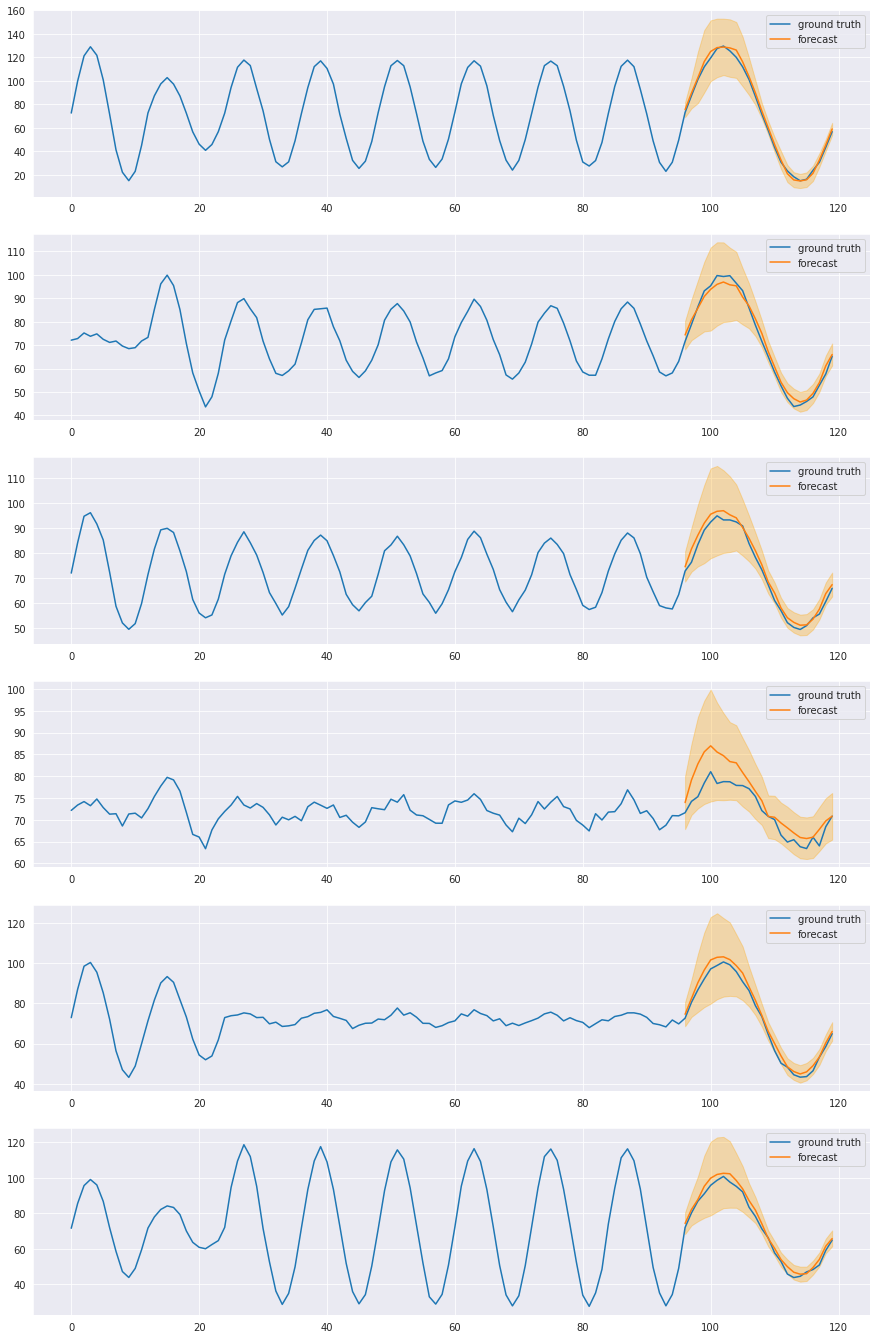

In [14]:
# canvas
fig, axes = plt.subplots(6,1, figsize=(15,24))

# sampling
sample_idxs = np.random.choice(input.shape[0], len(axes), replace=False)
input_sample, target_sample = input[sample_idxs], target[sample_idxs]

src, tgt = make_src_tgt(input_sample, t0, 24)

# plot
with torch.no_grad():
    src = torch.Tensor(src).to(device)
    tgt = torch.Tensor(tgt).to(device)
    target_sample = torch.Tensor(target_sample).to(device)
    infershort.plot((src,tgt), target_sample, axes)

## Long-term forecasting (i.e. with recurrence)

In [15]:
inferlong = InferLongTerm(model)

### Eval

In [16]:
running_loss, running_metric = 0.0, 0.0
with torch.no_grad():
    for (input_batch, target_batch) in tqdm(test_loader):
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        src, tgt = make_src_tgt(input_batch, t0, 24)
        loss, metric = inferlong.eval((src, tgt), target_batch)
        
        running_loss += loss.item()
        running_metric += metric.item()

print('Test loss:', running_loss / len(test_loader))
print('Test metric:', running_metric / len(test_loader))


100%|██████████| 16/16 [00:42<00:00,  2.69s/it]

Test loss: 79621799.5
Test metric: 7.540993750095367


### Plot samples

In [17]:
# canvas
fig, axes = plt.subplots(6, 1, figsize=(15, 24))

# sampling
sample_idxs = np.random.choice(input.shape[0], len(axes), replace=False)
input_sample, target_sample = input[sample_idxs], target[sample_idxs]

src, tgt = make_src_tgt(input_sample, t0, 24)

# plot
with torch.no_grad():
    src = torch.Tensor(src).to(device)
    tgt = torch.Tensor(tgt).to(device)
    target_sample = torch.Tensor(target_sample).to(device)
    inferlong.plot((src, tgt), target_sample, axes)
